# Imports

In [1]:
import sys

sys.path.append("../src")

In [17]:
import argparse
import glob
import json
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
import vtk
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from dtu_spine_config import DTUConfig

from scipy.ndimage import rotate
from scipy.ndimage import binary_dilation, binary_erosion

from skimage.transform import resize

# Target shape
target_shape = (105, 166, 70)

# Segmentation

(241, 241, 241)
[ 0 17 18 19 20 21 22]


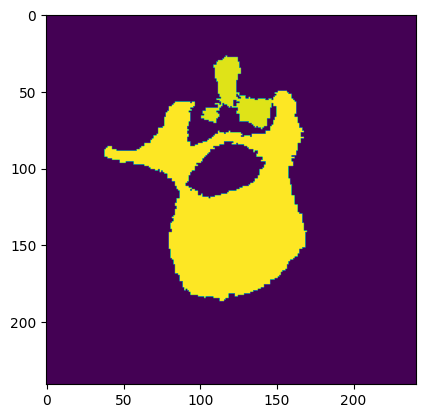

In [100]:
# L1 has label 20
label_id = 20
segmentation_name = ("sample_0097_crop_label.nii.gz")
segmentation_name = ("sample_0097_crop_label_warp_outlier.nii.gz")

# Read the segmentation and turn into a numpy array
try:
    img = sitk.ReadImage(segmentation_name)
except RuntimeError as e:
    print(f"Got an exception {str(e)}")
    print(f"Error reading {segmentation_name}")
    raise

segm_np = sitk.GetArrayFromImage(img)
print(segm_np.shape)
print(np.unique(segm_np))
plt.imshow(segm_np[120, :, :])

# Get training

In [105]:
training_id_list_file = "../challenge_results/custom_train_list_436.txt"
all_scan_ids = np.loadtxt(str(training_id_list_file), delimiter=",", dtype=str)
train_dir = ""
print(all_scan_ids)

['sample_0000' 'sample_0003' 'sample_0007' 'sample_0008' 'sample_0015'
 'sample_0016' 'sample_0017' 'sample_0018' 'sample_0020' 'sample_0025'
 'sample_0028' 'sample_0032' 'sample_0097']


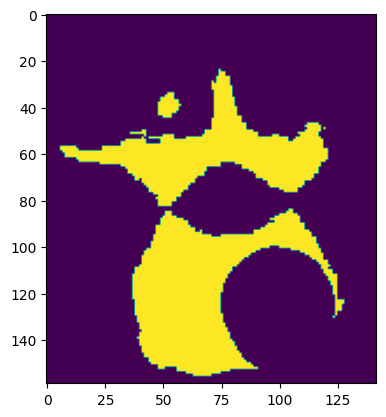

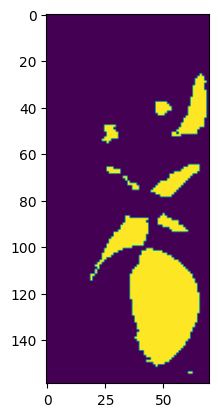

(103, 159, 70)


In [117]:
def align(segm_np):
    seg_where = np.where(segm_np == 20)
    segm_np = segm_np[
        seg_where[0].min() : seg_where[0].max(),
        seg_where[1].min() : seg_where[1].max(),
        seg_where[2].min() : seg_where[2].max(),
    ]
    # segm_np = segm_np[seg_where[0].min():seg_where[0].max(), ...]
    seg_where = np.where(segm_np == 20)
    com = seg_where[1].mean(), seg_where[2].mean()
    # mask = seg_where[1] < 120
    # seg_where = [seg[mask] for seg in seg_where]
    min_index = seg_where[1].argmin()
    vec0 = seg_where[2][min_index] - com[1], seg_where[1][min_index] - com[0]
    angle0 = np.arctan(vec0[1] / vec0[0]) - np.pi / 2

    segm_np_rot = (
        rotate(
            (segm_np == 20).astype(float),
            angle0 / np.pi * 180,
            axes=(1, 2),
            reshape=True,
            order=0,
        )
        > 0.5
    )
    return segm_np_rot


def get_diff(arr):
    # arr = arr == 20
    com_z = int(np.where(arr)[2].mean())

    overshoot = min(arr.shape[2] - 2 * com_z, 0)
    left = arr[..., abs(overshoot) : com_z]
    right = arr[..., com_z : min(arr.shape[2], 2 * com_z)]
    # return (left != np.flip(right, 2)).sum()
    # n = left.sum() + right.sum()
    # return (left != np.flip(right, 2)).sum() / n
    intersection = left != np.flip(right, 2)
    intersection = binary_erosion(intersection, iterations=1)
    # intersection = binary_dilation(intersection, iterations=1)
    union = left | np.flip(right, 2)
    return intersection
    # return intersection.sum() / union.sum()

rotated = align(segm_np)
plt.imshow(rotated[rotated.shape[0] // 2, ...])
plt.show()
diff = get_diff(rotated)
plt.imshow(diff[diff.shape[0] // 2, ...])
plt.show()
print(diff.shape)

In [161]:
diffs = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{id}_crop_label.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs.append(get_diff(align(segm_np)))

# Resize each 3D array to the target shape
data_list_resized = [resize(data, target_shape, mode='constant', anti_aliasing=False) for data in diffs]

# Now flatten and stack as before
flattened_data = [data.flatten() for data in data_list_resized]
stacked_data = np.vstack(flattened_data)

print(stacked_data.shape)

100%|██████████| 13/13 [00:06<00:00,  2.10it/s]


(13, 1220100)


In [107]:
pca = PCA(n_components=2)
pca.fit(stacked_data)

PCA(n_components=2)

In [162]:
diffs_out = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{id}_crop_label_warp_outlier.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs_out.append(get_diff(align(segm_np)))

# Resize each 3D array to the target shape
data_list_resized_out = [resize(data, target_shape, mode='constant', anti_aliasing=False) for data in diffs_out]

# Now flatten and stack as before
flattened_data_out = [data.flatten() for data in data_list_resized_out]
stacked_data_out = np.vstack(flattened_data_out)

print(stacked_data_out.shape)

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]


(13, 1220100)


In [113]:
diffs_sphere = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{id}_crop_label_sphere_outlier_water.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs_sphere.append(get_diff(align(segm_np)))

# Resize each 3D array to the target shape
data_list_resized_sphere = [resize(data, target_shape, mode='constant', anti_aliasing=False) for data in diffs_sphere]

# Now flatten and stack as before
flattened_data_sphere = [data.flatten() for data in data_list_resized_sphere]
stacked_data_sphere = np.vstack(flattened_data_sphere)

print(stacked_data_sphere.shape)

100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


(13, 1220100)


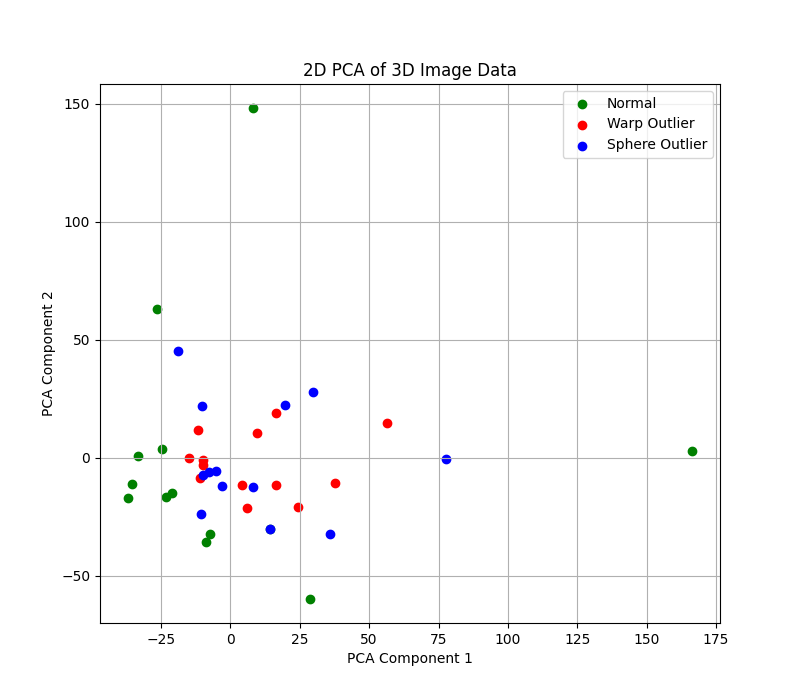

In [160]:
# Step 3: Transform both stacks using the trained PCA
stack1_pca = pca.transform(stacked_data)
stack2_pca = pca.transform(stacked_data_out)
stack_sphere_pca = pca.transform(stacked_data_sphere)

# Step 4: Plot the PCA results for both stacks
plt.figure(figsize=(8, 7))
plt.scatter(stack1_pca[:, 0], stack1_pca[:, 1], color='green', label='Normal')
plt.scatter(stack2_pca[:, 0], stack2_pca[:, 1], color='red', label='Warp Outlier')
plt.scatter(stack_sphere_pca[:, 0], stack_sphere_pca[:, 1], color='blue', label='Sphere Outlier')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of 3D Image Data')
plt.legend()
plt.grid(True)
plt.show()

In [122]:
pca_3d = PCA(n_components=3)
pca_3d.fit(stacked_data)

# Transform both stacks using the trained PCA
stack1_pca = pca_3d.transform(stacked_data)
stack2_pca = pca_3d.transform(stacked_data_out)
stack_sphere_pca = pca_3d.transform(stacked_data_sphere)

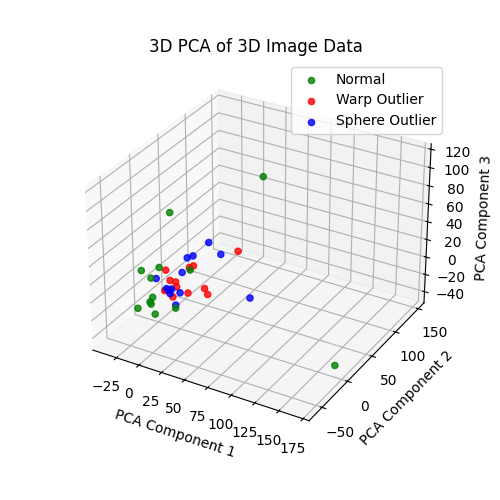

In [138]:
# Plot the 3D PCA results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(stack1_pca[:, 0], stack1_pca[:, 1], stack1_pca[:, 2], color='green', label='Normal', alpha=0.8)
ax.scatter(stack2_pca[:, 0], stack2_pca[:, 1], stack2_pca[:, 2], color='red', label='Warp Outlier', alpha=0.8)
ax.scatter(stack_sphere_pca[:, 0], stack_sphere_pca[:, 1], stack_sphere_pca[:, 2], color='blue', label='Sphere Outlier', alpha=0.8)

# Labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of 3D Image Data')
ax.legend()
plt.show()

In [165]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate synthetic data for demonstration
# Class A (healthy data)
np.random.seed(42)
class_A = stacked_data

# Class B (unhealthy data)
class_B = stacked_data_out + stacked_data_sphere

# Combine the data
data = np.vstack([class_A, class_B])
labels = np.array([1]*len(class_A) + [-1]*len(class_B))  # 1 for healthy (Class A), -1 for unhealthy (Class B)

# Split the data into training (only Class A) and evaluation (Class A and B)
train_data = class_A
test_data = data

# Initialize and train the Isolation Forest model
model = IsolationForest(contamination=0.3, random_state=42)
model.fit(train_data)

# Predict on test data
predictions = model.predict(test_data)

# Convert the predictions to a format compatible with classification_report
# -1 indicates an outlier, 1 indicates an inlier
binary_predictions = [1 if pred == 1 else -1 for pred in predictions]

# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(labels, binary_predictions, labels=[1, -1])
print(cm)

print("\nClassification Report:")
print(classification_report(labels, binary_predictions, target_names=['Healthy', 'Unhealthy']))


Confusion Matrix:
[[ 9  4]
 [ 0 13]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      1.00      0.87        13
   Unhealthy       1.00      0.69      0.82        13

    accuracy                           0.85        26
   macro avg       0.88      0.85      0.84        26
weighted avg       0.88      0.85      0.84        26



In [33]:
diffs_sphere = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{train_dir}/crops/{id}_crop_label_sphere_outlier_water.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs_sphere.append(get_diff(align(segm_np)))

  0%|          | 0/436 [00:00<?, ?it/s]

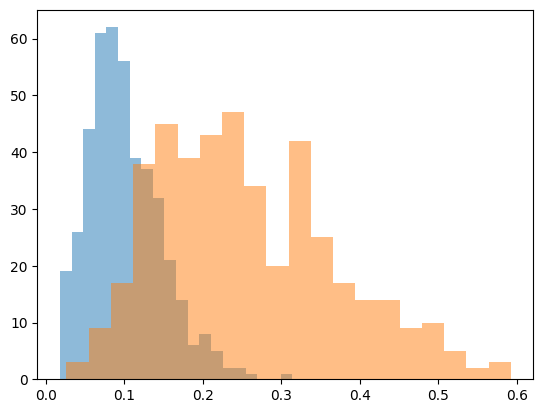

In [34]:
fig, ax = plt.subplots(1, 1, sharex=True)

ax.hist(diffs, alpha=0.5, bins=20)
ax.hist(diffs_sphere, alpha=0.5, bins=20);

In [35]:
diffs[0], diffs_sphere[0]

(0.07959342804017736, 0.4243014206066118)

# Method

In [38]:
threshold = np.quantile(diffs, 0.95)
threshold

0.19053592528785745

In [66]:
def align(segm_np):
    seg_where = np.where(segm_np == 20)
    segm_np = segm_np[
        seg_where[0].min() : seg_where[0].max(),
        seg_where[1].min() : seg_where[1].max(),
        seg_where[2].min() : seg_where[2].max(),
    ]

    seg_where = np.where(segm_np == 20)
    com = seg_where[1].mean(), seg_where[2].mean()

    min_index = seg_where[1].argmin()
    vec0 = seg_where[2][min_index] - com[1], seg_where[1][min_index] - com[0]
    angle0 = np.arctan(vec0[1] / vec0[0]) - np.pi / 2

    segm_np_rot = (
        rotate(
            (segm_np == 20).astype(float),
            angle0 / np.pi * 180,
            axes=(1, 2),
            reshape=True,
            order=0,
        )
        > 0.5
    )
    return segm_np_rot

def get_diff(arr):
    com_z = int(np.where(arr)[2].mean())

    overshoot = min(arr.shape[2] - 2 * com_z, 0)
    left = arr[..., abs(overshoot) : com_z]
    right = arr[..., com_z : min(arr.shape[2], 2 * com_z)]

    intersection = left != np.flip(right, 2)
    intersection = binary_erosion(intersection, iterations=1)
    union = left | np.flip(right, 2)
    return intersection.sum() / union.sum()

def detect_outlier_symmetry(settings, threshold=0.19):
    data_dir = settings["data_dir"]
    segmentation_dir = os.path.join(data_dir, "train/crops")
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")
    test_id_list_file = os.path.join(result_dir, test_list)
    
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    outliers_pred = []
    outliers_gt = []
    for idx in tqdm(all_scan_ids):
        scan_id = idx[0].strip()
        outlier_type = idx[1].strip()
        
        # surf_name = os.path.join(surface_dir, f"{scan_id}_surface{outlier_type}.vtk")
        segmentation_name = f"{segmentation_dir}/{scan_id}_crop_label{outlier_type}.nii.gz"

        # Read the segmentation and turn into a numpy array
        try:
            img = sitk.ReadImage(segmentation_name)
        except RuntimeError as e:
            print(f"Got an exception {str(e)}")
            print(f"Error reading {segmentation_name}")
            raise
    
        volume_seg = sitk.GetArrayFromImage(img)

        left_right_diff = get_diff(align(volume_seg))
        outlier_pred = left_right_diff > threshold

        outliers_pred.append(outlier_pred)
        outliers_gt.append(outlier_type != "")

    # Create classification results
    validation_results = []
    for i, id in enumerate(all_scan_ids):
        scan_id = id[0].strip()
        # Remember to cast bools to int for json serialization
        validation_results.append(
            {
                "scan_id": scan_id,
                "outlier": int(outliers_pred[i]),
                # "outlier_probability": outlier_probs[i],
                # "outlier_threshold": normalized_threshold,
            }
        )

    # Write classification results to file
    with open(validation_results_json, "w") as json_file:
        json.dump(validation_results, json_file, indent=4)

def unpack_results(settings):
    data_dir = settings["data_dir"]
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")

    test_id_list_file = os.path.join(result_dir, test_list)
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    with open(validation_results_json, "r") as json_file:
        validation_results = json.load(json_file)
    
    outliers_pred = []
    outliers_gt = []
    for i, id in enumerate(all_scan_ids):
        scan_id = id[0].strip()
        outlier_type = id[1].strip()
        
        outlier_pred = validation_results[i]["outlier"]
        outlier_gt = outlier_type != ""

        outliers_pred.append(bool(outlier_pred))
        outliers_gt.append(outlier_gt)
    return np.array(outliers_pred, dtype=bool), np.array(outliers_gt, dtype=bool)

def get_metrics(outliers_pred, outliers_gt):
    n_samples = outliers_gt.size
    
    # Compute metrics
    tp = np.sum(outliers_gt & outliers_pred)
    tn = np.sum(~outliers_gt & ~outliers_pred)
    fp = np.sum(~outliers_gt & outliers_pred)
    fn = np.sum(outliers_gt & ~outliers_pred)
    print(
        f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn} N_pred: {outliers_pred.sum()} N_samples: {n_samples}"
    )
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / n_samples
    cohens_kappa = (
        2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))
    )
    print(
        f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, Accuracy: {accuracy:.2f}, "
        f"Cohens kappa: {cohens_kappa:.2f}"
    )

In [67]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_validation_list_110.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_validation_list_110.txt'}

In [68]:
detect_outlier_symmetry(settings)

Found 220 test samples in ../challenge_results/custom_validation_list_110.txt


  0%|          | 0/220 [00:00<?, ?it/s]

In [69]:
outliers_pred, outliers_gt = unpack_results(settings)

Found 220 test samples in ../challenge_results/custom_validation_list_110.txt


In [70]:
get_metrics(outliers_pred, outliers_gt)

TP: 124, TN: 47, FP: 8, FN: 41 N_pred: 132 N_samples: 220
Precision: 0.94, Recall: 0.75, F1: 0.84, Accuracy: 0.78, Cohens kappa: 0.51


## Validation